In [1]:
%cd \Users\user\Downloads\

/Users/user/Downloads


In [2]:
import pandas as pd
from sklearn import linear_model,tree, ensemble,decomposition,datasets,preprocessing, grid_search
from sklearn.metrics import roc_curve, auc
import numpy as np
import pylab as pl
import datetime
import re
from nltk.tag import pos_tag
from sklearn.decomposition import ProjectedGradientNMF
import sklearn.feature_extraction.text as text
%matplotlib inline

In [3]:
train = pd.read_csv("NYTimesBlogTrain.csv")
test = pd.read_csv("NYTimesBlogTest.csv")

In [4]:
#Random sampling
num_obs = len(train)
num_train_sample = int((num_obs) * 0.70)

from random import sample

#create random index
rindex = np.array(sample(xrange(len(train)),num_train_sample))

#get "num_train_sample" random rows from train

train_df = train.ix[rindex]

train_df_cv = train.drop(rindex)

In [5]:
print "number of obs for training:",len(train_df)
print "number of obs for cross validation:",len(train_df_cv)
print "number of obs for test dataset:",len(test)

number of obs for training: 4572
number of obs for cross validation: 1960
number of obs for test dataset: 1870


In [6]:
#Available columns in training dataset
list(train.columns)

['NewsDesk',
 'SectionName',
 'SubsectionName',
 'Headline',
 'Snippet',
 'Abstract',
 'WordCount',
 'PubDate',
 'Popular',
 'UniqueID']

In [7]:
#Available columns in test dataset
list(test.columns)

['NewsDesk',
 'SectionName',
 'SubsectionName',
 'Headline',
 'Snippet',
 'Abstract',
 'WordCount',
 'PubDate',
 'UniqueID']

In [8]:
print 'Number of variables in training dataset',len(train_df.columns)
print 'Number of variables in test dataset',len(test.columns)

Number of variables in training dataset 10
Number of variables in test dataset 9


## Training Dataset

In [9]:
train_df.head(2)

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,Popular,UniqueID
3749,OpEd,Opinion,NaN,Republicans Against Toll Roads,"The allure of a free lunch is hard to resist, ...","The allure of a free lunch is hard to resist, ...",239,2014-10-20 16:15:05,1,3750
5846,Science,Health,NaN,Vegetarian Thanksgiving: Vegan Mac N Cheez,Vegan diners and people who cant tolerate dair...,Vegan diners and people who cant tolerate dair...,402,2014-11-18 14:58:58,0,5847


In [10]:
train_df['Headline_len'] = train_df.Headline.map(lambda x: len(x))
train_df['PubDate_year'] = train_df.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').year)
train_df['PubDate_month'] = train_df.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').month)
train_df['PubDate_day'] = train_df.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').day)
train_df['PubDate_hour'] = train_df.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').hour)
train_df['PubDate_wkday'] = train_df.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').weekday())

In [11]:
print 'Popular : True    = ' , len(train_df.loc[train_df['Popular'] == 1])
print 'Popular : False   = ' , len(train_df.loc[train_df['Popular'] == 0])
print 'Percentage of True = ' , np.round((float(len(train_df.loc[train_df['Popular'] == 1]))/ (len(train_df.loc[train_df['Popular'] == 1]) + len(train_df.loc[train_df['Popular'] == 0]))) * 100,2),'%'

Popular : True    =  757
Popular : False   =  3815
Percentage of True =  16.56 %


In [12]:
#List columns that will be included in the model
train_cols = [
 'WordCount',
 'Headline_len',
 'PubDate_year',
 'PubDate_month',
 'PubDate_day',
 'PubDate_hour',
 'PubDate_wkday']

#### Fit Model

In [13]:
X_train = train_df[train_cols].values
Y_train = train_df['Popular'].values

In [14]:
#Model = ensemble.GradientBoostingRegressor()
#Model = linear_model.LinearRegression()
Model = ensemble.ExtraTreesRegressor(n_estimators = 50)
Model.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=False, compute_importances=None,
          criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
          min_samples_split=2, n_estimators=50, n_jobs=1, oob_score=False,
          random_state=None, verbose=0)

## CROSS VALIDATION DATASET

In [15]:
train_df_cv['Headline_len'] = train_df_cv.Headline.map(lambda x: len(x))
train_df_cv['PubDate_year'] = train_df_cv.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').year)
train_df_cv['PubDate_month'] = train_df_cv.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').month)
train_df_cv['PubDate_day'] = train_df_cv.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').day)
train_df_cv['PubDate_hour'] = train_df_cv.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').hour)
train_df_cv['PubDate_wkday'] = train_df_cv.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').weekday())

In [16]:
X_cv = train_df_cv[train_cols].values

#### Predict Cross Validation

In [17]:
Output_cv  = Model.predict(X_cv)

In [18]:
Table = pd.DataFrame(Output_cv,columns=["_Predicted_"])
Table["Actual"] = train_df_cv['Popular'].values

In [19]:
Table['Predicted'] = Table._Predicted_.map(lambda x: 0 if x < 0 else x)

In [20]:
Table.head()

,_Predicted_,Actual,Predicted
0,0.54,0,0.54
1,0.44,1,0.44
2,0.40,1,0.40
3,0.10,1,0.10
4,0.02,0,0.02


In [21]:
print 'Actual',np.mean(Table['Actual'])
print 'Predicted',np.mean(Table['Predicted'])

Actual 0.171428571429
Predicted 0.180326530612


In [22]:
print 'Actual Received True     = ' , len(Table.loc[Table['Actual'] == 1])
print 'Actual Received False    = ' , len(Table.loc[Table['Actual'] == 0])
print 'Predicted Received True  = ' , len(Table.loc[Table['Predicted'] == 1 ])
print 'Predicted Received False = ' , len(Table.loc[Table['Predicted'] < 0.5])
print ''
print 'True Positive  = ', len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)])
print 'False Positive = ', len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)])
print 'True Negative  = ', len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 0)])
print 'False Negative = ', len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 1)])
print ''
print 'True Positive Rate   = ', np.round((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 1)]))) * 100),2),'%'
print 'False Positive Rate  = ', np.round((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 0)]))) * 100),2),'%'
print 'True Negative Rate   = ', np.round((1-(len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 0)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 0)]))))) * 100,2),'%'
print 'False Negative Rate  = ', np.round((1-(len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)])/float((len(Table[(Table['Predicted'] >= 0.5) & (Table['Actual'] == 1)]) + len(Table[(Table['Predicted'] < 0.5) & (Table['Actual'] == 1)]))))) * 100,2),'%'

Actual Received True     =  336
Actual Received False    =  1624
Predicted Received True  =  4
Predicted Received False =  1770

True Positive  =  107
False Positive =  83
True Negative  =  1541
False Negative =  229

True Positive Rate   =  31.85 %
False Positive Rate  =  5.11 %
True Negative Rate   =  94.89 %
False Negative Rate  =  68.15 %


Area under the ROC curve : 0.781874


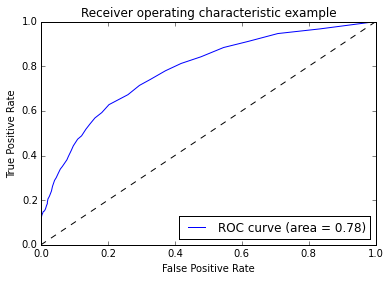

In [23]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Table['Actual'],Table['Predicted'])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

## Test Dataset

In [24]:
test['Headline_len'] = test.Headline.map(lambda x: len(x))
test['PubDate_year'] = test.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').year)
test['PubDate_month'] = test.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').month)
test['PubDate_day'] = test.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').day)
test['PubDate_hour'] = test.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').hour)
test['PubDate_wkday'] = test.PubDate.map(lambda x: datetime.datetime.strptime(x[2:],'%y-%m-%d %H:%M:%S').weekday())

In [25]:
X_test = test[train_cols].values
Output_test  = Model.predict(X_test)

In [26]:
ids  = pd.DataFrame(test['UniqueID'])
predicted = pd.DataFrame(Output_test)

In [27]:
Table2 = ids.join(predicted)
Table2.columns = ['UniqueID','_Probability1_']

In [28]:
Table2['Probability1'] = Table2._Probability1_.map(lambda x: 0 if x < 0 else x)

In [29]:
Table2.head(3)

,UniqueID,_Probability1_,Probability1
0,6533,0.70,0.70
1,6534,0.24,0.24
2,6535,0.70,0.70


In [30]:
np.mean(Table2['Probability1'])

0.19337967914438503

In [31]:
np.std(Table2['Probability1'])

0.20405624739378067

In [32]:
np.min(Table2['Probability1'])

0.0

In [33]:
print 'True' , len(Table2.loc[Table2['Probability1'] >= 0.5])
print 'False' , len(Table2.loc[Table2['Probability1'] < 0.5])

True 191
False 1679


In [34]:
Table2 = Table2[['UniqueID','Probability1']]

In [35]:
Table2.head(3)

,UniqueID,Probability1
0,6533,0.70
1,6534,0.24
2,6535,0.70


In [36]:
#Export file
Table2.to_csv('ExtraTrees1.csv',index=False)